## Init

In [69]:
import os

path = os.getcwd()
# set the working directory
os.chdir('c:\\Github\\new-peak-project\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [70]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [71]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

### Notebook Parameters

In [76]:
import os

# parameters
notebook_name = 'test1'

# Generation of ground truth model

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)

# Simulation parameters

simulation_time = 500
simulation_step = 100

# Feature data generation

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000
feature_generation_seed = 50  # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed


data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

# General parameters
parallelise = True
save_figures = True
experiment_id = notebook_name + '_' + \
    str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/test1_4_50/


In [77]:
import os

path = os.getcwd()
# set the working directory
os.chdir('c:\\Github\\new-peak-project\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [78]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [79]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Loading FGFR4 model

In [80]:
with open('scripts/FGFR4_model_rev2a.ant', 'r') as file:
    model_string = file.read()

In [81]:
model_string

'model FGFR4_RTK_model\n\n# Reactions\nJ0_f: IGFR -> pIGFR; kc01f * IGF * IGFR\nJ0_r: pIGFR -> IGFR; Vm01r * (1 + ki01r*PTP) * pIGFR\nJ1_f: FGFR4 -> pFGFR4; kc02f * FGF * FGFR4 /(1 + Ki02f*(FGFR4i^n02/(Kmf02^n02 + FGFR4i^n02)))\nJ1_r: pFGFR4 -> FGFR4; Vm02r *  (1 + ki02r1*PTP)*(1 + ki02r2*aCbl) * pFGFR4\nJ2_f: ERBB -> pERBB; (kc03f * HRG + kc03f2 * FOXO)* ERBB / (1+ ki03f *pERK) / (1 + Ki03f2*(ERBBi/(Kmf03 + ERBBi)))\nJ2_r: pERBB -> ERBB; Vm03r *  (1 + ki03r*PTP)  * pERBB\nJ3_f: IRS -> pIRS; kc04f * pIGFR * IRS  / (1+ ki04f *pS6K)\nJ3_r: pIRS -> IRS; Vm04r * pIRS\nJ4_f: PI3K -> aPI3K; (kc05f1 * pIRS + kc05f2 * (aGAB1 + aGAB2) + kc05f3 * aRas + kc05f4 * pERBB) * PI3K /(1 + Ki06f*(PI3Ki^n06/(Kmf06^n06 + PI3Ki^n06)))\nJ4_r: aPI3K -> PI3K; Vm05r * aPI3K\nJ5_f: PIP2 -> PIP3; kc06f * aPI3K * PIP2\nJ5_r: PIP3 -> PIP2; kc06r * PTEN * PIP3\nJ6_f: PDK1 -> aPDK1; kc07f * PIP3 * PDK1\nJ6_r: aPDK1 -> PDK1; Vm07r * aPDK1\nJ7_f: Akt -> pAkt; (kc08f * aPDK1 + kc08f1 * amTORC2) * Akt / (1 + Ki08f*(AKTi

In [82]:
from models.Solver.ScipySolver import ScipySolver
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

new_scipy_solver = ScipySolver()
new_rr_solver = RoadrunnerSolver()

new_scipy_solver.compile(model_string)

In [83]:
import antimony

ant_model = model_string
antimony.clearPreviousLoads()
antimony.freeAll()
code = antimony.loadAntimonyString(ant_model)
if code >= 0:
    mid = antimony.getMainModuleName()
    sbml_model = antimony.getSBMLString(mid)

new_rr_solver.compile(sbml_model)

In [84]:
print(sbml_model)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by libAntimony version v2.15.0 with libSBML version 5.20.2. -->
<sbml xmlns="http://www.sbml.org/sbml/level3/version2/core" level="3" version="2">
  <model metaid="FGFR4_RTK_model" id="FGFR4_RTK_model">
    <listOfCompartments>
      <compartment sboTerm="SBO:0000410" id="default_compartment" spatialDimensions="3" size="1" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="IGFR" compartment="default_compartment" initialConcentration="7.58" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="pIGFR" compartment="default_compartment" initialConcentration="0" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="FGFR4" compartment="default_compartment" initialConcentration="962.77" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="pFGFR4" compartment="default_compartment" initialConc

In [97]:
result = new_rr_solver.simulate(0, 5000, 5000)


In [98]:
result

,time,IGFR,pIGFR,FGFR4,pFGFR4,aCbl,ERBB,pERBB,FOXO,pERK,...,aRaf,SPRY2,MEK,pMEK,ERK,GAB1,GAB2,Cbl,pFOXO,mTORC2
0,0.0000,7.58,0.000000e+00,962.77,0.000000e+00,0.000000,680.210000,0.000000,1025.000000,0.000000,...,0.000000,0.0,1997.800000,0.000000,2054.400000,20.030000,4.260000,5.430000,1025.000000,13.170000
1,1.0002,7.58,0.000000e+00,962.77,0.000000e+00,5.421543,10.325382,669.884618,960.605338,1471.801455,...,26.910146,0.0,1657.209815,340.590185,582.598545,0.041693,0.015195,0.008457,1089.394662,9.220935
2,2.0004,7.58,0.000000e+00,962.77,0.000000e+00,5.421564,13.104380,667.105620,355.897856,2048.756969,...,25.942772,0.0,1276.471888,721.328112,5.643031,0.053151,0.047007,0.008436,1694.102144,3.636370
3,3.0006,7.58,0.000000e+00,962.77,0.000000e+00,5.421564,18.761608,661.448392,29.947332,2052.291598,...,24.782999,0.0,998.232647,999.567353,2.108402,0.046888,0.079546,0.008436,2020.052668,1.238765
4,4.0008,7.58,0.000000e+00,962.77,0.000000e+00,5.421564,25.232809,654.977191,5.023500,2052.674015,...,23.744536,0.0,793.119763,1204.680237,1.725985,0.044576,0.111154,0.008436,2044.976500,0.455787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995.9992,7.58,0.000000e+00,962.77,0.000000e+00,5.421481,592.416290,87.793710,3.191136,2053.321340,...,20.204576,0.0,94.215515,1903.584485,1.078660,0.043810,0.532272,0.008519,2046.808864,0.130669
4996,4996.9994,7.58,0.000000e+00,962.77,0.000000e+00,5.421481,592.416290,87.793710,3.191136,2053.321340,...,20.204576,0.0,94.215515,1903.584485,1.078660,0.043810,0.532272,0.008519,2046.808864,0.130669
4997,4997.9996,7.58,0.000000e+00,962.77,0.000000e+00,5.421481,592.416290,87.793710,3.191136,2053.321340,...,20.204576,0.0,94.215515,1903.584485,1.078660,0.043810,0.532272,0.008519,2046.808864,0.130669
4998,4998.9998,7.58,0.000000e+00,962.77,0.000000e+00,5.421481,592.416290,87.793710,3.191136,2053.321340,...,20.204576,0.0,94.215515,1903.584485,1.078660,0.043810,0.532272,0.008519,2046.808864,0.130669


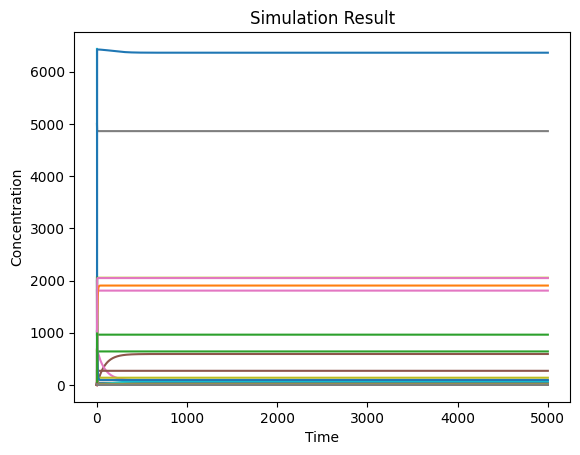

In [99]:
# plot result in a basic way 
import matplotlib.pyplot as plt
# extract columns from result
time = result['time']
species = result.columns[1:]
# plot each species
for specie in species:
    plt.plot(time, result[specie], label=specie)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulation Result')
# plt.legend()
plt.show()

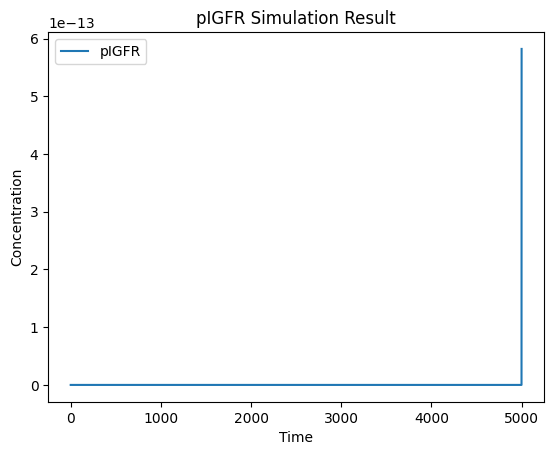

In [100]:
# plot only the 'pIGFR' species
plt.plot(time, result['pIGFR'], label='pIGFR')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('pIGFR Simulation Result')
plt.legend()
plt.show()